In [1]:
import pandas as pd
import numpy as np
import pickle


import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

import itertools
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


df_train = pd.read_csv('data/t2e/text_train.csv')
df_test = pd.read_csv('data/t2e/text_test.csv')

df = pd.concat([df_train, df_test], ignore_index=True)
display(df.head())


,wav_file,label,transcription
0,Ses01M_script01_1_M006,2,i don t know .
1,Ses01M_script03_1_M014,2,darling don t say that .
2,Ses01F_impro07_M009,1,mmhmm . mmhmm . yay . so what major ? what are...
3,Ses01M_impro07_M006,1,i don t know . i should ask . yeah i will .
4,Ses01F_script02_1_F007,0,how s that supposed to make me feel ?


In [24]:
# Menampilkan 5 baris pertama data training
print("Sample data training (5 baris pertama):")
print(df_train[:5])

# Menampilkan 5 baris pertama data testing
print("\nSample data testing (5 baris pertama):")
print(df_test[:5])

Sample data training (5 baris pertama):
                 wav_file  label  \
0  Ses01M_script01_1_M006      2   
1  Ses01M_script03_1_M014      2   
2     Ses01F_impro07_M009      1   
3     Ses01M_impro07_M006      1   
4  Ses01F_script02_1_F007      0   

                                       transcription  
0                                     i don t know .  
1                           darling don t say that .  
2  mmhmm . mmhmm . yay . so what major ? what are...  
3        i don t know . i should ask . yeah i will .  
4              how s that supposed to make me feel ?  

Sample data testing (5 baris pertama):
                 wav_file  label  \
0  Ses01F_script02_2_M001      1   
1     Ses01M_impro04_F015      5   
2     Ses01F_impro04_M006      5   
3  Ses01M_script01_2_M007      5   
4  Ses01F_script02_1_F004      5   

                                       transcription  
0                        well so what do you think ?  
1                    you kind of have a short 

In [2]:
col = ['label', 'transcription']
df = df[col]

In [3]:
df.columns

Index(['label', 'transcription'], dtype='object')

In [4]:
df.columns = ['label', 'transcription']

In [5]:
category_to_id = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}
id_to_category = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

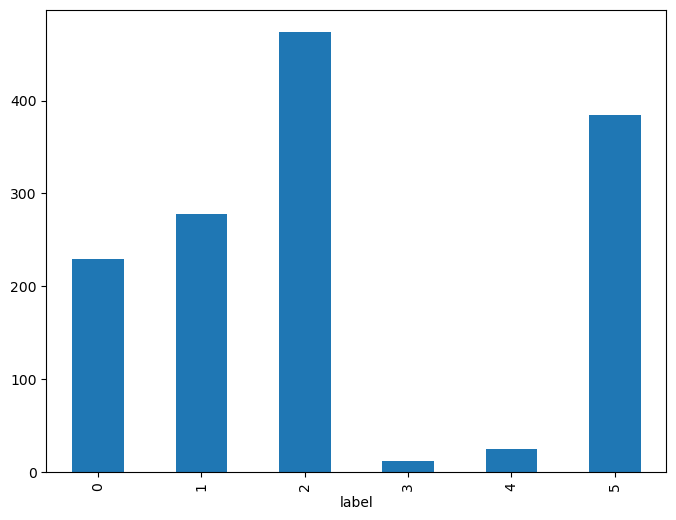

In [6]:
fig = plt.figure(figsize=(8,6))
df.groupby('label').transcription.count().plot.bar(ylim=0)
plt.show()

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.transcription).toarray()

labels = df.label
print(features.shape)

(1402, 258)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)
# count_vect = CountVectorizer()
# x_train_counts = count_vect.fit_transform(x_train)
# tfidf_transformer = TfidfTransformer()
# x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [26]:
# Menampilkan 5 baris pertama data training
print("Sample data training (5 baris pertama):")
print(x_train[:5])

# Menampilkan 5 baris pertama data testing
print("\nSample data testing (5 baris pertama):")
print(x_test[:5])


Sample data training (5 baris pertama):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Sample data testing (5 baris pertama):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

In [25]:
# Menampilkan 5 baris pertama data training
print("Sample data training (5 baris pertama):")
print(x_train[:5])

# Menampilkan 5 baris pertama data testing
print("\nSample data testing (5 baris pertama):")
print(y_train[:5])


Sample data training (5 baris pertama):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Sample data testing (5 baris pertama):
754     0
792     5
1241    2
442     1
388     1
Name: label, dtype: int64


Test Set Accuracy =  0.491
Test Set F-score =  0.385
Test Set Precision =  0.402
Test Set Recall =  0.380
Confusion matrix, without normalization
[[16  3 16  0 11]
 [ 4 21 13  0 10]
 [10  7 59  0 29]
 [ 0  1  1  0  4]
 [ 5  3 26  0 42]]


c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


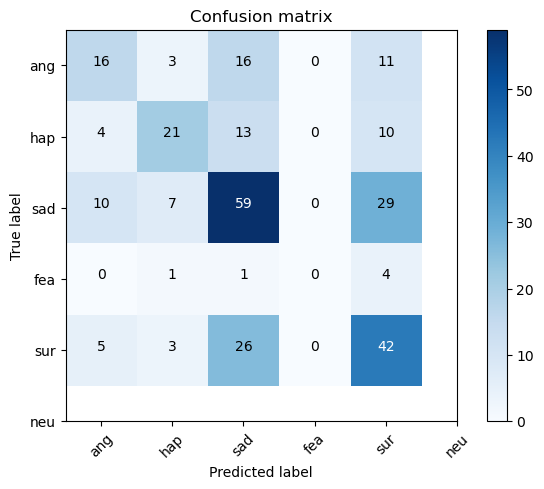

In [10]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\xgboost\training.py:183: UserWarning: [03:35:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Set Accuracy =  0.452
Test Set F-score =  0.266
Test Set Precision =  0.346
Test Set Recall =  0.260
Confusion matrix, without normalization
[[ 9  1 32  0  0  4]
 [ 1 14 25  1  0  7]
 [ 6  3 82  0  0 14]
 [ 0  0  0  0  0  0]
 [ 0  1  3  0  0  2]
 [ 2  1 51  0  0 22]]


c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


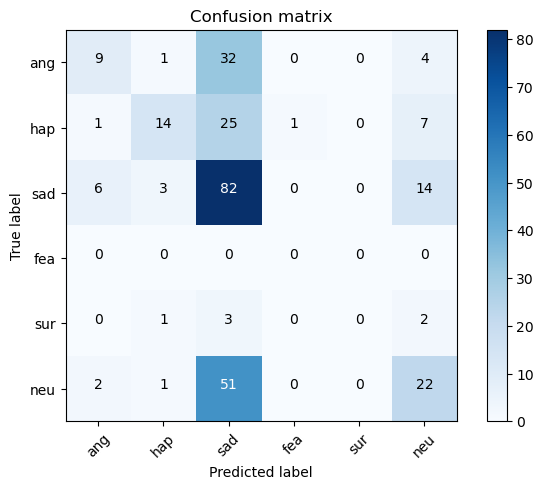

In [11]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=600, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.477
Test Set F-score =  0.318
Test Set Precision =  0.322
Test Set Recall =  0.319
Confusion matrix, without normalization
[[18  4 14  0  0 10]
 [ 5 23 10  1  0  9]
 [10  9 50  0  0 36]
 [ 0  0  0  0  0  0]
 [ 0  1  1  0  0  4]
 [ 9  5 19  0  0 43]]


c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


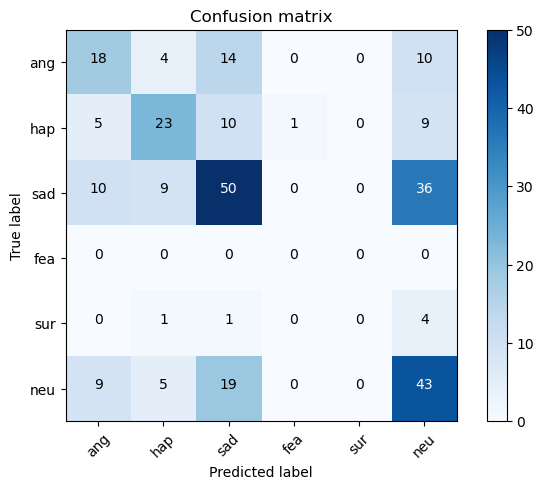

In [12]:
svc_classifier = LinearSVC()

svc_classifier.fit(x_train, y_train)

# Predict
pred = svc_classifier.predict(x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emotion_dict.keys())
(y_test, pred_probs)

with open('pred_probas/text_svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.480
Test Set F-score =  0.366
Test Set Precision =  0.421
Test Set Recall =  0.357
Confusion matrix, without normalization
[[12  5 26  0  3]
 [ 2 23 16  0  7]
 [ 3  5 74  0 23]
 [ 0  0  4  0  2]
 [ 2  6 42  0 26]]


c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


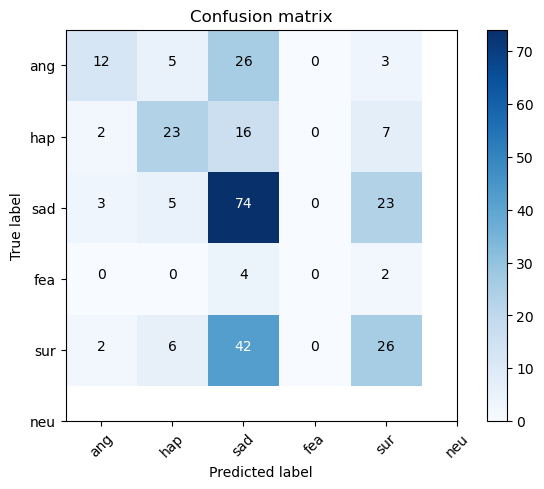

In [13]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.445
Test Set F-score =  0.356
Test Set Precision =  0.360
Test Set Recall =  0.356
Confusion matrix, without normalization
[[17  5 19  1  4]
 [ 7 25 15  0  1]
 [11 12 56  0 26]
 [ 0  0  4  0  2]
 [ 7  7 35  0 27]]


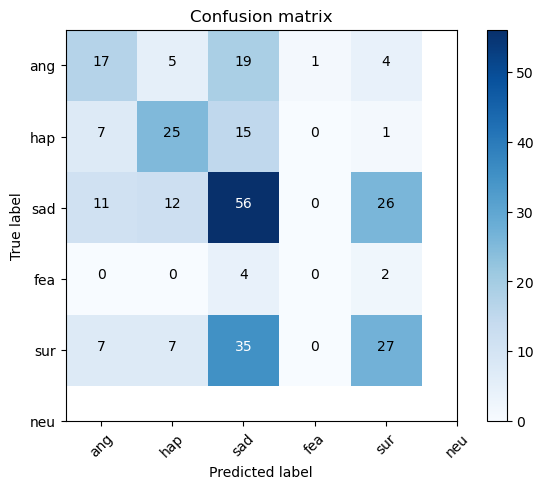

In [14]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Set Accuracy =  0.491
Test Set F-score =  0.378
Test Set Precision =  0.404
Test Set Recall =  0.371
Confusion matrix, without normalization
[[16  4 24  0  2]
 [ 6 22 15  0  5]
 [ 5  7 73  0 20]
 [ 0  0  4  0  2]
 [ 5  6 38  0 27]]


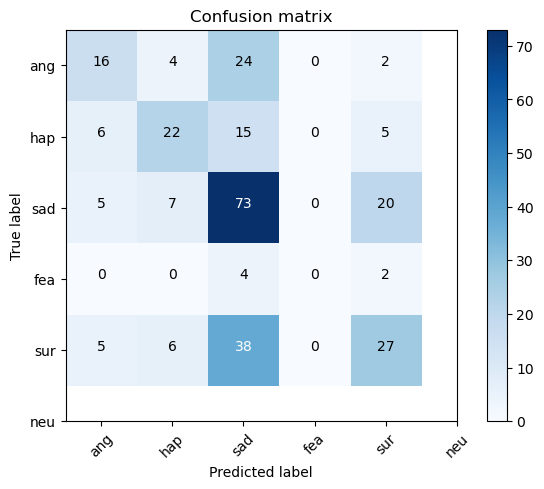

In [15]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_results(y_test, pred_probs)

with open('pred_probas/text_lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

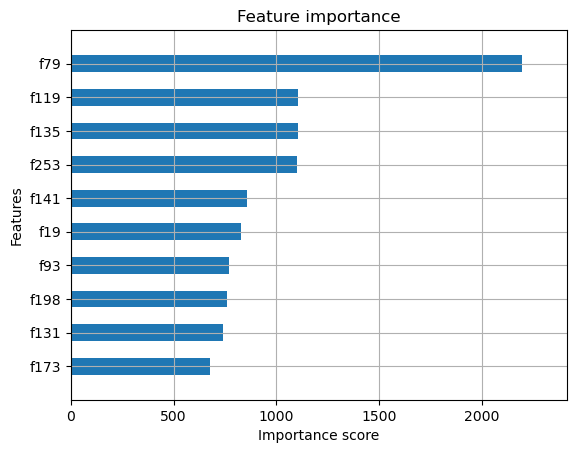

In [16]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)

In [17]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([7.9213697e-03, 0.0000000e+00, 1.1342766e-02, 6.9440724e-03,
       7.2437329e-03, 6.2932833e-03, 4.8977491e-03, 0.0000000e+00,
       7.8564743e-03, 3.3806809e-03, 4.6168338e-03, 4.8632855e-03,
       5.2984101e-03, 3.6258069e-03, 0.0000000e+00, 9.3435738e-03,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.8976197e-03,
       0.0000000e+00, 5.7613794e-03, 0.0000000e+00, 6.5520974e-03,
       0.0000000e+00, 5.5817445e-03, 0.0000000e+00, 4.1030934e-03,
       0.0000000e+00, 0.0000000e+00, 8.6221593e-03, 5.3552655e-03,
       5.3208284e-03, 0.0000000e+00, 5.0983261e-03, 0.0000000e+00,
       8.5244160e-03, 5.4294989e-03, 3.9413827e-03, 0.0000000e+00,
       0.0000000e+00, 5.8097686e-03, 6.4468775e-03, 6.3037118e-03,
       0.0000000e+00, 6.3992236e-03, 7.2407075e-03, 6.9125560e-03,
       4.0061628e-03, 6.4779213e-03, 0.0000000e+00, 7.8594228e-03,
       0.0000000e+00, 5.6167822e-03, 2.3010487e-03, 0.0000000e+00,
       0.0000000e+00, 1.1683633e-02, 0.0000000e+00, 0.0000000e

In [18]:
# with open('pred_probas/text_lstm_classifier.pkl', 'rb') as f:
#     lstm_pred_probs = pickle.load(f)
    
# display_results(y_test, lstm_pred_probs)

Test Set Accuracy =  0.477
Test Set F-score =  0.379
Test Set Precision =  0.399
Test Set Recall =  0.372
Confusion matrix, without normalization
[[17  4 21  0  4]
 [ 2 24 15  0  7]
 [ 9  7 64  0 25]
 [ 0  0  4  0  2]
 [ 4  7 36  0 29]]


c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


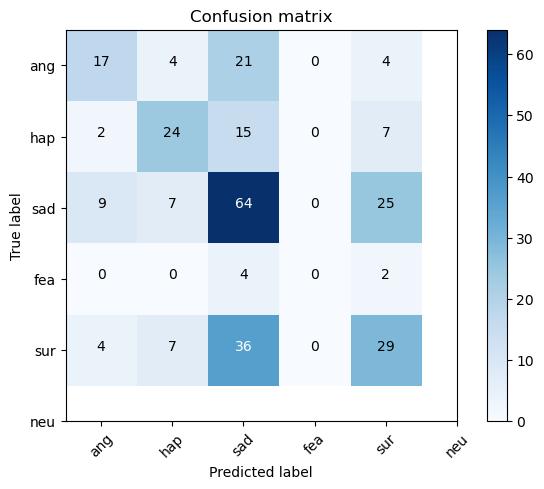

In [19]:
# Load predicted probabilities
with open('pred_probas/text_rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('pred_probas/text_xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/text_svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/text_mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/text_mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('pred_probas/text_lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)


# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/5.0


# Show metrics
display_results(y_test, ensemble_pred_probs)

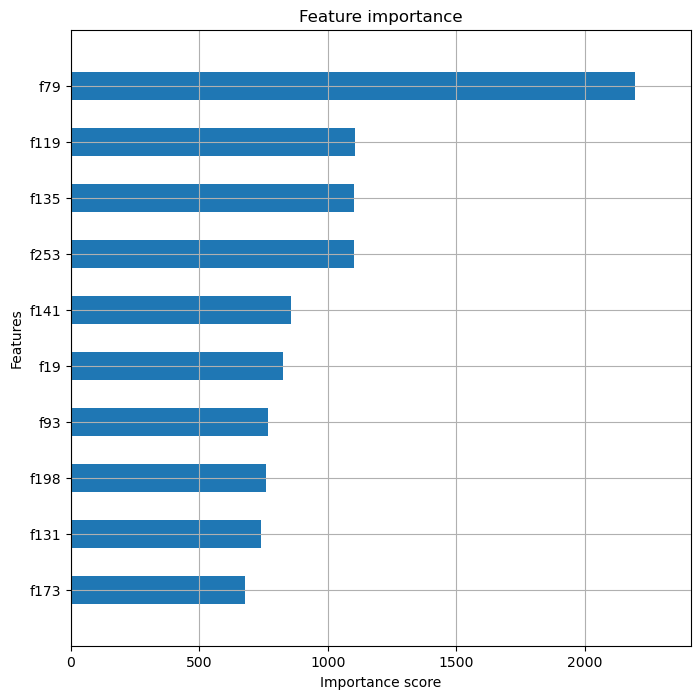

In [20]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)

In [21]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([7.9213697e-03, 0.0000000e+00, 1.1342766e-02, 6.9440724e-03,
       7.2437329e-03, 6.2932833e-03, 4.8977491e-03, 0.0000000e+00,
       7.8564743e-03, 3.3806809e-03, 4.6168338e-03, 4.8632855e-03,
       5.2984101e-03, 3.6258069e-03, 0.0000000e+00, 9.3435738e-03,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.8976197e-03,
       0.0000000e+00, 5.7613794e-03, 0.0000000e+00, 6.5520974e-03,
       0.0000000e+00, 5.5817445e-03, 0.0000000e+00, 4.1030934e-03,
       0.0000000e+00, 0.0000000e+00, 8.6221593e-03, 5.3552655e-03,
       5.3208284e-03, 0.0000000e+00, 5.0983261e-03, 0.0000000e+00,
       8.5244160e-03, 5.4294989e-03, 3.9413827e-03, 0.0000000e+00,
       0.0000000e+00, 5.8097686e-03, 6.4468775e-03, 6.3037118e-03,
       0.0000000e+00, 6.3992236e-03, 7.2407075e-03, 6.9125560e-03,
       4.0061628e-03, 6.4779213e-03, 0.0000000e+00, 7.8594228e-03,
       0.0000000e+00, 5.6167822e-03, 2.3010487e-03, 0.0000000e+00,
       0.0000000e+00, 1.1683633e-02, 0.0000000e+00, 0.0000000e

In [22]:
import xgboost as xgb
print(xgb.__version__)


3.0.1


In [23]:

%pip install --upgrade "xgboost>=1.7.3"

# Pastikan xgb_classifier sudah fit dulu
xgb_classifier.fit(x_train, y_train)

top_n = [100, 400, 500, 600]  # number of features
for n in top_n:
    threshold_index = np.argsort(contribution_scores)[::-1][:n][-1]
    threshold_value = contribution_scores[threshold_index]
    print('Stats for top {} features:'.format(n))
    
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=threshold_value, prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(
        max_depth=7,
        learning_rate=0.008,
        objective='multi:softprob',
        n_estimators=600,
        subsample=0.8,  # perbaikan parameter
        num_class=len(emotion_dict),
        booster='gbtree',
        n_jobs=4
    )
    select_xgb_classifier.fit(select_x_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)

    # Results
    display_results(y_test, pred_probs, cm=False)


Note: you may need to restart the kernel to use updated packages.


c:\Users\Unity_Comp\anaconda3\envs\cudaRun\lib\site-packages\xgboost\training.py:183: UserWarning: [03:35:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Stats for top 100 features:
Test Set Accuracy =  0.416
Test Set F-score =  0.339
Test Set Precision =  0.550
Test Set Recall =  0.315
Stats for top 400 features:
Test Set Accuracy =  0.434
Test Set F-score =  0.362
Test Set Precision =  0.577
Test Set Recall =  0.333
Stats for top 500 features:
Test Set Accuracy =  0.434
Test Set F-score =  0.362
Test Set Precision =  0.577
Test Set Recall =  0.333
Stats for top 600 features:
Test Set Accuracy =  0.434
Test Set F-score =  0.362
Test Set Precision =  0.577
Test Set Recall =  0.333
